IMPORT LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


LOAD CLEAN DATA

In [9]:
df = pd.read_csv(
    r"D:\decision-intelligence-project\Data\Processed_Data\clean_transactions.csv",
    dtype={"InvoiceNo": "str"},
    low_memory=False
)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Quarter,Revenue,Channel,Promotion_Flag,Profit_Margin,Profit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,2010Q4,15.30,Online,0,0.235824,3.608111
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2010Q4,20.34,Offline,0,0.355912,7.239256
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,2010Q4,22.00,Offline,0,0.166214,3.656700
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2010Q4,20.34,Online,0,0.218856,4.451527
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2010Q4,20.34,Online,0,0.310762,6.320903


BUILD RFM FEATURES

In [10]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

    Create RFM Table

In [12]:
rfm = (
    df.groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("Revenue", "sum")
    )
    .reset_index()
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


SCALE FEATURES 

    REQUIRED FOR KMEANS

In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

FIND OPTIMAL CLUSTERS

    ELBOW METHOD

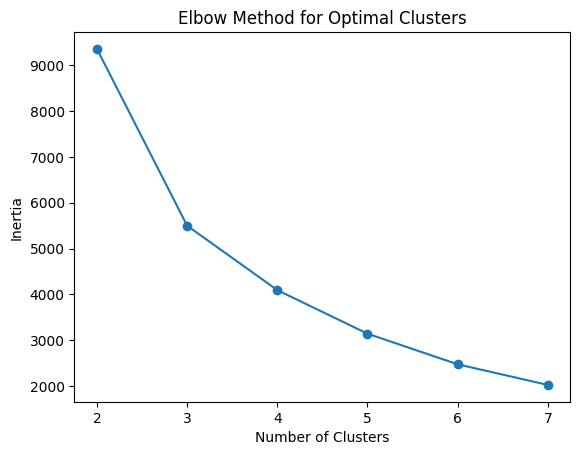

In [14]:
inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

APPLY KMEANS 

    FINAL MODEL

Text(0.5, 1.02, 'RFM Segmentation Clusters')

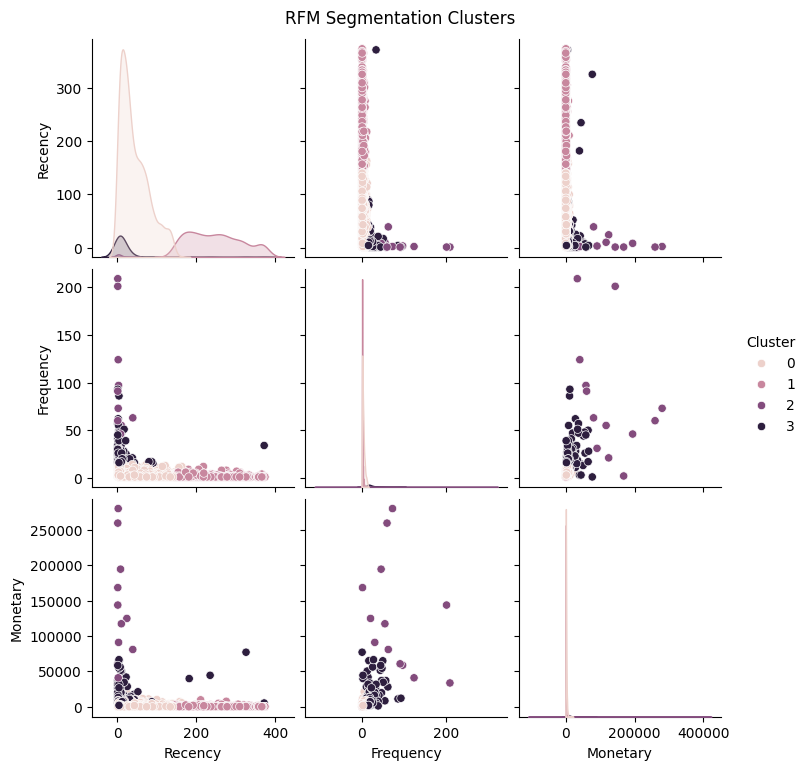

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()
sns.pairplot(rfm, hue="Cluster", vars=["Recency", "Frequency", "Monetary"])
plt.suptitle("RFM Segmentation Clusters", y=1.02)

INTERPRET CLUSTERS 

    THIS IS CRITICAL

array([[<Axes: title={'center': 'Avg_Recency'}, xlabel='Cluster'>],
       [<Axes: title={'center': 'Avg_Frequency'}, xlabel='Cluster'>],
       [<Axes: title={'center': 'Avg_Monetary'}, xlabel='Cluster'>]],
      dtype=object)

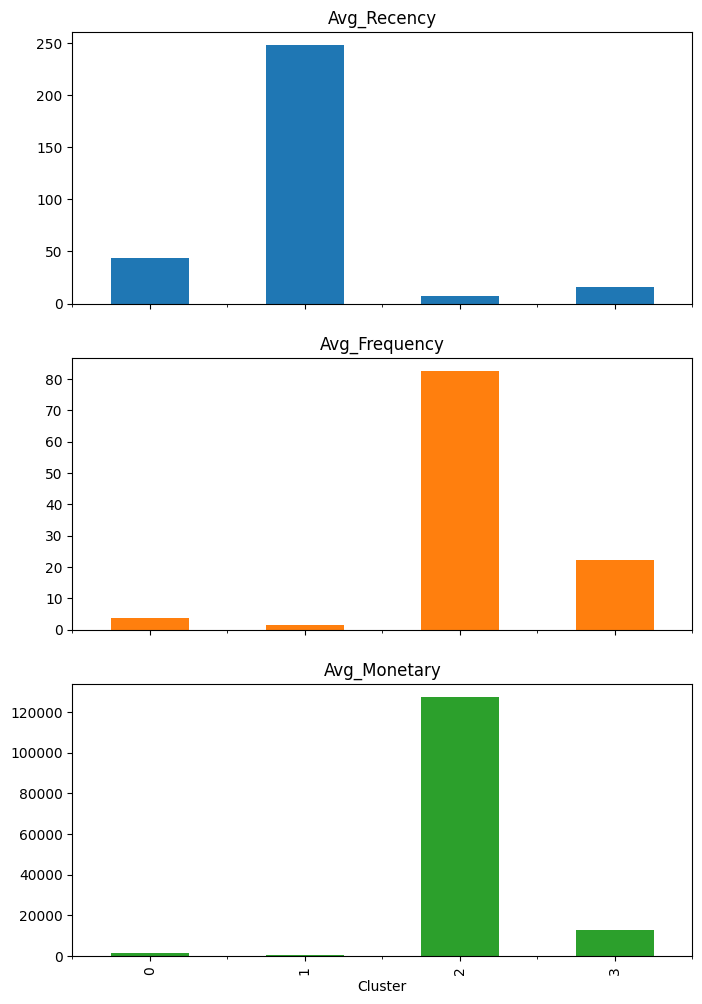

In [16]:
cluster_summary = (
    rfm.groupby("Cluster")
    .agg(
        Avg_Recency=("Recency", "mean"),
        Avg_Frequency=("Frequency", "mean"),
        Avg_Monetary=("Monetary", "mean"),
        Customer_Count=("CustomerID", "count")
    )
    .reset_index()
)

cluster_summary
cluster_summary.plot(
    kind="bar",
    x="Cluster",
    y=["Avg_Recency", "Avg_Frequency", "Avg_Monetary"],
    subplots=True,
    layout=(3, 1),
    figsize=(8, 12),
    legend=False
)

MAP CLUSTERS > EXECUTIVE DECISIONS 

    THE MAGIC

In [17]:
def map_decision(row):
    if row["Avg_Monetary"] > 3000 and row["Avg_Frequency"] > 10:
        return "Defend (High Value Loyal)"
    elif row["Avg_Monetary"] > 1500:
        return "Invest (High Potential)"
    elif row["Avg_Frequency"] > 5:
        return "Grow Selectively"
    else:
        return "Exit / Deprioritize"

cluster_summary["Decision_Action"] = cluster_summary.apply(map_decision, axis=1)

cluster_summary

,Cluster,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count,Decision_Action
0,0,43.702685,3.682711,1359.049284,3054,Exit / Deprioritize
1,1,248.075914,1.552015,480.617480,1067,Exit / Deprioritize
2,2,7.384615,82.538462,127338.313846,13,Defend (High Value Loyal)
3,3,15.500000,22.333333,12709.090490,204,Defend (High Value Loyal)


MERGE DECISIONS BACK TO CUSTOMERS

In [19]:
rfm = rfm.merge(
    cluster_summary[["Cluster", "Decision_Action"]],
    on="Cluster",
    how="left"
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Decision_Action_x,Decision_Action_y
0,12346.0,326,1,77183.60,3,Defend (High Value Loyal),Defend (High Value Loyal)
1,12347.0,2,7,4310.00,0,Exit / Deprioritize,Exit / Deprioritize
2,12348.0,75,4,1797.24,0,Exit / Deprioritize,Exit / Deprioritize
3,12349.0,19,1,1757.55,0,Exit / Deprioritize,Exit / Deprioritize
4,12350.0,310,1,334.40,1,Exit / Deprioritize,Exit / Deprioritize


SAVE SEGMENTATION OUTPUT

In [26]:
import os

output_dir = r"D:\decision-intelligence-project\Data\processed"
os.makedirs(output_dir, exist_ok=True)
rfm.to_csv(f"{output_dir}/customer_segmentation.csv", index=False)
cluster_summary.to_csv(f"{output_dir}/segment_decision_summary.csv", index=False)

